# PAA Fast Gain Optimised Array Design

## Imports

In [4]:
import pandas as pd
import random
import math

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sn


import time
from tqdm import tqdm
import scipy



import os, sys
import csv


## Classes

In [5]:
"""
Classes for beamforming
"""
class Antenna():
    def __init__(self,x,y,z):
        self.x = x
        self.y = y
        self.z = z
    
    def read_sig(self,wave):
        pass
        
class Source():
    def __init__(self,freq,speed,source_pos):
        self.freq = freq
        self.speed = speed
        self.source_pos = source_pos
        
    def sig_at_time_and_location(self,pos,time):
        x1,y1,z1 = pos
        x0,y0,z0 = self.source_pos
        d = np.sqrt((x0-x1)**2+(y0-y1)**2+(z0-z1)**2)
        pi2f = 2*np.pi*self.freq
        wavelength = self.speed/self.freq
        sig = np.sin((2*np.pi*d)/wavelength + 2*np.pi*self.freq*time)/d
        return sig

## Functions

### Creating the SMP and PCB models


In [45]:
# Generate thin rectangles for the PCBs and the other rectangles for the SMP connectors

def generate_PCB_rect(ant_pos,dc_orien):
    if dc_orien == 1:
        centre_pos = (ant_pos[0]+12.5e-1,ant_pos[1])
    else:
        centre_pos = (ant_pos[0]-12.5e-1,ant_pos[1])
    cent_x = centre_pos[0]
    cent_y = centre_pos[1]
    p1 = (cent_x-PCB_width/2,cent_y-PCB_height/2)
    p2 = (p1[0]+PCB_width,p1[1])
    p3 = (p2[0],p2[1]+PCB_height)
    p4 = (p1[0],p3[1])
    return p1,p2,p3,p4

def generate_SMP_rect(ant_pos,dc_orien):
    if dc_orien == 1:
        centre_pos = (ant_pos[0]+28e-1,ant_pos[1]+(5e-1-PCB_height/2))
    else:
        centre_pos = (ant_pos[0]-28e-1,ant_pos[1]-(5e-1-PCB_height/2))
    cent_x = centre_pos[0]
    cent_y = centre_pos[1]
    p1 = (cent_x-SMP_width/2,cent_y-SMP_height/2)
    p2 = (p1[0]+SMP_width,p1[1])
    p3 = (p2[0],p2[1]+SMP_height)
    p4 = (p1[0],p3[1])
    return p1,p2,p3,p4

def generate_WWC_rect(ant_pos,dc_orien):
    if dc_orien == 1:
        centre_pos = (ant_pos[0]-1.3+WWC_width/2,ant_pos[1]+WWC_vertical_offset)
    else:
        centre_pos = (ant_pos[0]+1.3-WWC_width/2,ant_pos[1]-WWC_vertical_offset)
    cent_x = centre_pos[0]
    cent_y = centre_pos[1]
    p1 = (cent_x-WWC_width/2,cent_y-WWC_height/2)
    p2 = (p1[0]+WWC_width,p1[1])
    p3 = (p2[0],p2[1]+WWC_height)
    p4 = (p1[0],p3[1])
    return p1,p2,p3,p4


### Collision Checkers

In [7]:
def antennas_inside_bounds(array):
    inside_bounds = True
    for pos in array:
        if check_inner_circle(pos)==False:
            inside_bounds = False
            break
    return inside_bounds
def check_inner_circle(pos):
    # This is just for the antennas
    r = array_radius
    x,y = pos
    # The r here is used to define the centre
    return ((x-r)**2+(y-r)**2)<(inner_array_radius-ant_radius)**2

def no_collisions_all_in_bounds(array,DCs):
    safe_state = rects_inside_bounds(array,DCs) and no_rect_collisions(array,DCs) and no_ant_ant_collisions(array) and antennas_inside_bounds(array)
    
    return safe_state
    

def no_ant_ant_collisions(array):
    """
    This functions simply finds all the antenna pair separations and checks whether or not the minimum separation
    is greater than the antenna diamter
    """
    try:
        min_seps = min(calc_separations(array))
    except:
        min_seps = 4*ant_radius
    if min_seps<=2*ant_radius:
        return False
    else:
        return True
    
def no_rect_collisions(array,DCs):
    """
    This function will check whether or not any of the SMP or PCB rectangles collide
    """
    # Generate the positions/coordinates of all the PCBs
    PCB_coords = []
    SMP_coords = []
    WWC_coords = []
    
    for ant_indx in range(len(array)):
        dc_orien = DCs[ant_indx]
        ant_pos = array[ant_indx]
        PCB = generate_PCB_rect(ant_pos,dc_orien)
        SMP = generate_SMP_rect(ant_pos,dc_orien)
        WWC = generate_WWC_rect(ant_pos,dc_orien)
        PCB_coords.append(PCB)
        SMP_coords.append(SMP)
        WWC_coords.append(WWC)
        
    # We only need to see if all the PCBs have any collisions with either other PCBs or any of the SMPs
    is_collision = False
    
    for PCB_indx1 in range(len(array)):
        
        # This loop will check to see if any of the PCBs collide with any other PCBs
        for PCB_indx2 in range(len(array)):
            if PCB_indx2!=PCB_indx1:
                # So as long it isn't the same one
                rect1,rect2 = PCB_coords[PCB_indx2],PCB_coords[PCB_indx1]
                collision = two_rect_intersect(rect1,rect2)
                if collision:
                    is_collision = True
                    break
                    
        # This loop will check to see if any of the PCBs collide with any of the SMPs
        for SMP_indx in range(len(array)):
            if PCB_indx1!=SMP_indx:
                rect1,rect2 = PCB_coords[PCB_indx1],SMP_coords[SMP_indx]
                collision = two_rect_intersect(rect1,rect2)
                if collision:
                    is_collision = True
                    break
        
        
        # Check to see if any PCB collides with any WWC
        for WWC_indx in range(len(array)):
            if PCB_indx1!=WWC_indx:
                # So as long it isn't the same one
                rect1,rect2 = PCB_coords[PCB_indx1],WWC_coords[WWC_indx]
                collision = two_rect_intersect(rect1,rect2)
                if collision:
                    is_collision = True
                    break
        
    for SMP_indx1 in range(len(array)):     
        for SMP_indx2 in range(len(array)):
            if SMP_indx1!=SMP_indx2:
                rect1,rect2 = SMP_coords[SMP_indx1],SMP_coords[SMP_indx2]
                collision = two_rect_intersect(rect1,rect2)
                if collision:
                    is_collision = True
                    break
                    
        for WWC_indx in range(len(array)):
            if SMP_indx1!=WWC_indx:
                rect1,rect2 = SMP_coords[SMP_indx1],WWC_coords[WWC_indx]
                collision = two_rect_intersect(rect1,rect2)
                if collision:
                    is_collision = True
                    break
                    
    for WWC_indx1 in range(len(array)):     
        for WWC_indx2 in range(len(array)):
            if WWC_indx1!=WWC_indx2:
                rect1,rect2 = WWC_coords[WWC_indx1],WWC_coords[WWC_indx2]
                collision = two_rect_intersect(rect1,rect2)
                if collision:
                    is_collision = True
                    break             
    
    
    return not(is_collision)

    
def point_inside_rect(point_pos,rect):
    R1,R2,R3,R4 = rect
    x,y = point_pos
    if R1[0]<=x<=R2[0] and R1[1]<=y<=R4[1]:
        return True
    else:
        return False
    
    
def two_rect_intersect(rect1, rect2):
    bottom_left1, bottom_right1, top_right1, top_left1 = rect1
    bottom_left2, bottom_right2, top_right2, top_left2 = rect2
    return not(top_right1[0] < bottom_left2[0] or bottom_left1[0] > top_right2[0] or top_right1[1] < bottom_left2[1] or bottom_left1[1] > top_right2[1])


def rects_inside_bounds(array,DCs):
    """
    This function will check whether or not any of the SMP or PCB rectangles lie outside the outer circular boundary
    """
    # Generate the positions/coordinates of all the PCBs
    PCB_coords = []
    SMP_coords = []
    WWC_coords = []
    collision = False
    for ant_indx in range(len(array)):
        dc_orien = DCs[ant_indx]
        ant_pos = array[ant_indx]
        PCB = generate_PCB_rect(ant_pos,dc_orien)
        SMP = generate_SMP_rect(ant_pos,dc_orien)
        WWC = generate_WWC_rect(ant_pos,dc_orien)
        
        PCB_coords.append(PCB)
        SMP_coords.append(SMP)
        WWC_coords.append(WWC)
        # Check the SMP
        for coord in SMP:
            if check_bounds(coord,array_radius,0) == False:
                # Outside circle
                collision = True
                break
                
            
            
        # Check the PCB
        for coord in PCB:
            if check_bounds(coord,array_radius,0) == False:
                # Outside circle
                collision = True
                break
        # Check the WWC
        for coord in WWC:
            if check_bounds(coord,array_radius,0) == False:
                # Outside circle
                collision = True
                break
    return not(collision)
        
def check_bounds(pos,r,d):
    """
    This function checks whether a certain position lies inside a circle of centre (a,b) and radius r. 
    d repressent the min distance the point can get to the circle
    """
    a,b = array_radius,array_radius
    x,y = pos
    return ((x-a)**2+(y-b)**2)<(r-d)**2
        

### Functions for the Optimisation Process

In [8]:
def switch_DC_orien(ant_num,score_array):
    
    # Flip the down converter's orientation
    flip_dc(ant_num)
    safe = no_collisions_all_in_bounds(array,DCs)
    
    if safe:
        new_score = score_array(array)
        flip_dc(ant_num)
        old_score = score_array(array)
        # If the score has improved then flip it back to its new position
        if new_score>old_score:
            flip_dc(ant_num)
    else:
        flip_dc(ant_num)
        
    

def nudge_antenna(array,ant_num,tries_per_ant,score_array):
    global DCs

    x_old,y_old = array[ant_num]

    old_score = score_array(array)

    for j in range(tries_per_ant):
        
        x_nudge = np.random.normal(0,array_radius/3)
        y_nudge = np.random.normal(0,array_radius/3)

        x_new,y_new = x_old+x_nudge, y_old+y_nudge
        array[ant_num]=(x_new,y_new)

        good_move = no_collisions_all_in_bounds(array,DCs)
        
        
        if good_move:
            new_score = score_array(array)
            if new_score<old_score:
                # Then it was worse than before soo move it back
                array[ant_num]=(x_old,y_old)
        else:
            # There was a collision or something was out of bounds
            array[ant_num]=(x_old,y_old)
            
        

        # Fix antenna number 1 in place
    #if ant_num==0:
    #    array[ant_num]=(x_old,y_old)
    #    DCs[ant_num] = 1

def optimise_array_design(array,iterations,tries_per_ant):
    global DCs, the_best_array_DCs
    count = 0 
    scores = []
    score_array = main_scoring_function
    the_best_array = array
    best_array_score = score_array(array)
    the_best_array_DCs = DCs.copy()
    for n in range(iterations):
        start_time = time.time()
        # Looping through each antenna and maybe nudging it a bit into a new better location
        for x in range(len(array)):
            count+=1

            # If you chose the option to switch scoring functions every n iterations
            if scoring_func_alternate:

                if n%every_n_iterations==0:
                    score_array = minor_scoring_function
                    #if score_array==score_array_bow:
                        # Then set the scroign function to be the hist scoring func
                   #     score_array = score_array_hist
                   # else:
                        # Then set the scroign function to be the bow scoring func
                   #     score_array = score_array_bow
                else:
                    score_array = main_scoring_function
            nudge_antenna(array,x,tries_per_ant,score_array)
            switch_DC_orien(x,score_array)
            score = main_scoring_function(array)
            if score>best_array_score:
                the_best_array = array.copy()
                the_best_array_DCs = the_best_array_DCs.copy()
                best_array_score = score
            scores.append(score)
            
        save_array_to_csv(the_best_array,"best_array.csv")
        save_DCs(the_best_array_DCs,"best_array_DCs.csv")
        tpi = time.time()-start_time
        print("-------------------------------------")
        print(f"Iteration: {n+1}. Trial Nudge No: {count}. Score: {round(score,5)}.")
        #print(f"All ok still? {no_collisions_all_in_bounds(array,DCs)}")
        print(f"Time Per iteration: {round(tpi,3)}s\n")
        print("Array saved")
        print("-------------------------------------")
        
        
        
    return scores,the_best_array,the_best_array_DCs

def flip_dc(ant_num):
    global DCs
    # Save old coords
    x,y = array[ant_num]
    # Set new coords
    array[ant_num] = (x+(PCB_width-2.6)*DCs[ant_num],y)
    # Change dc orientaion
    DCs[ant_num] *= -1



### Initial Array Generation 

In [9]:
def flip_dc2(ant_num,array,DCs):

    # Save old coords
    x,y = array[ant_num]
    # Set new coords
    array[ant_num] = (x+(PCB_width-2.6)*DCs[ant_num],y)
    # Change dc orientaion
    DCs[ant_num] *= -1
    return array,DCs

def build_array(num_ants):
    array = []
    DCs = np.array([random.choice([1,-1]) for c in range(num_ants)])
    

    centre_pos = (array_radius,array_radius)
    array.append(centre_pos)

    

    for trial_ant_indx in (range(num_ants)):
        
        # If it can't place it after 1,000 tries its probably not going to 
        for trial_placement in range(2000):
            
            
            saved_array = array.copy()
            x_pos,y_pos = np.random.uniform(0,array_radius*2),np.random.uniform(0,array_radius*2)
            array.append((x_pos,y_pos))
            
            try:
                good_move = no_collisions_all_in_bounds(array,DCs)
                if good_move==False:
                    array = saved_array.copy()
                else:
                    if random.choice([1,0])==1:
                        array,DCs = flip_dc2(trial_ant_indx,array,DCs)
                        if not(no_collisions_all_in_bounds(array,DCs)):
                            
                            array,DCs = flip_dc2(trial_ant_indx,array,DCs)
                    break


            except:
                array = saved_array.copy()
                #print("Placed all antennas down")
                break
           
    return array,DCs


### Saving and Loading Arrays and DC Orientations

In [10]:

def save_array_to_csv(array,filename):
    x_values = [array[i][0] for i in range(len(array))]
    y_values = [array[i][1] for i in range(len(array))]
    array_df = pd.DataFrame()
    array_df["x"] = x_values
    array_df["y"] = y_values
    
    array_df.to_csv(f"{filename}",index=False)
    
def load_array(filename):
    array_df = pd.read_csv(filename)
    array = [(array_df["x"][i], array_df["y"][i]) for i in range(len(array_df))]
    return array
def load_DCs(filename):

    DCs_df = pd.read_csv(filename,names=["DC_Orien"])
    DCs=DCs_df["DC_Orien"]
    return DCs


def save_DCs(DCs,filename):
   
    DCs = list(DCs)

    np.savetxt(filename, 
               DCs,
               delimiter =", ", 
               fmt ='% s')

def load_in_array(filename):
    array_radius = 9.75/100
    global freq,speed
    df = pd.read_csv(filename)
    array = []
    for r in range(len(df)):
        array.append(Antenna(df["x"][r]/100-array_radius,df["y"][r]/100-array_radius,0))
    # Make each antenna a source

    # Source properties:
    speed = 3e8

    # They all lie on Z=0
    sources = [Source(freq,speed,(array[i].x,array[i].y,0)) for i in range(len(array))]
    return array,sources


### Stats about Array

In [11]:
def pair_finder(array):
    pairs = []
    N = len(array)  # Or you could do the length of the array
    for i in range(N):
        # The first antanna will have antenna number 0 to match pythonic indices
        for j in range(N):
            if i < j:
                pair = (array[i], array[j])
                pairs.append(pair)
    return pairs

def mae(a,b):
    a = np.array(a)
    b = np.array(b)
    res = (np.abs(a-b)).mean()
    return res
def calc_separations(array):
    pairs = pair_finder(array)
    separations = []
    for pair in pairs:
        x1 ,y1= pair[0][0],pair[0][1]
        x2 ,y2= pair[1][0],pair[1][1]
        separation = np.sqrt((y2-y1)**2+(x2-x1)**2)
        separations.append(separation)
    return separations

def calc_separationsxy(array):
    pairs = pair_finder(array)
    separationsx = []
    separationsy = []
    for pair in pairs:
        x1 ,y1= pair[0][0],pair[0][1]
        x2 ,y2= pair[1][0],pair[1][1]
        separationx = np.abs(x2-x1)
        separationsx.append(separationx)
        separationy = np.abs(y2-y1)
        separationsy.append(separationy)
    return separationsx,separationsy


def calc_pair_angles(array,pairs):
    angles = []
    for pair_indx in range(len(pairs)):
        pair = pairs[pair_indx]
        
        x1,x2 = pair[0][0],pair[1][0]
        y1,y2 = pair[0][1],pair[1][1]

        angle = math.atan2((y2-y1),(x2-x1))
        if angle >= np.pi:
            angle += -np.pi
        angles.append(angle)
    return angles


### Scoring Functions

In [13]:

def score_array_angles_bow(array):
    pairs = pair_finder(array)
    angles = calc_pair_angles(array,pairs)
    


    # Sort the separation values in assending order
    angles_sorted = np.sort(angles)
    # Calculating the sum of the mean squared errors of the x and y 
    max_angle = max(angles_ideal)
    mae_sum =  mae(angles_sorted/max_angle,angles_ideal/max_angle)

    
    return (1/mae_sum) 

def calc_gain(Im):
    
    center_image,outside_image = cut_out_center(Im, circle_gain_crop_radius)
    
    gain = max(center_image)/max(outside_image)
    return gain

def score_gain_fast(array):
    filename = "temp_array.csv"
    save_array_to_csv(array,filename)
    
    I = create_image(filename)
    
    gain = calc_gain(I)
    
    return gain
    
    

### Visualisation

In [14]:
def display_array(array):
    
    plt.figure(figsize=(10,10),dpi=40)
    plt.title("Array Design", fontsize=20)
    df_temp = pd.DataFrame(array,columns=["x","y"])
    sn.scatterplot(data=df_temp, x="x",y="y",s=200, marker="x",color="black")
    plt.xlabel("x (cm)",fontsize=20)
    plt.ylabel("y (cm)",fontsize=20)
    plt.xlim(0,2*array_radius)
    plt.ylim(0,2*array_radius)
    
    plt.show()




def display_array_full(array,DCs):

    plt.figure(figsize=(10,10),dpi=100)

    # Plot the antennas
    x_positions = [array[i][0] for i in range(len(array))]
    y_positions = [array[i][1] for i in range(len(array))]
    plt.scatter(x_positions,y_positions,s=700)



    # Plotting the outer bounding circle
    thetas = np.linspace(0,2*np.pi,50)
    x_values = array_radius*np.cos(thetas) + array_radius
    y_values = array_radius*np.sin(thetas)  + array_radius
    plt.plot(x_values,y_values,color="red")


    # Plotting the inner bounding circle
    thetas = np.linspace(0,2*np.pi,50)
    x_values = inner_array_radius*np.cos(thetas) + array_radius
    y_values = inner_array_radius*np.sin(thetas)  + array_radius
    plt.plot(x_values,y_values,color="black")

    # Plotting the PCBs
    PCBs = [generate_PCB_rect(array[i],DCs[i]) for i in range(len(array))]
    for rect in PCBs:
        p1,p2,p3,p4 = rect
        plt.plot([p1[0],p2[0],p3[0],p4[0],p1[0]],[p1[1],p2[1],p3[1],p4[1],p1[1]],color="black",linewidth=1.5)



    # Plotting the SMPs
    SMPs = [generate_SMP_rect(array[i],DCs[i]) for i in range(len(array))]
    for rect in SMPs:
        p1,p2,p3,p4 = rect
        plt.plot([p1[0],p2[0],p3[0],p4[0],p1[0]],[p1[1],p2[1],p3[1],p4[1],p1[1]],color="green",linewidth=1.5)

    # Plotting the WWCs
    WWCs = [generate_WWC_rect(array[i],DCs[i]) for i in range(len(array))]
    for rect in WWCs:
        p1,p2,p3,p4 = rect
        plt.plot([p1[0],p2[0],p3[0],p4[0],p1[0]],[p1[1],p2[1],p3[1],p4[1],p1[1]],color="purple",linewidth=1.5)



    plt.xlabel("x (cm)",fontsize=19)
    plt.ylabel("y (cm)",fontsize=19)
    plt.xlim([0,array_radius*2])
    plt.ylim([0,array_radius*2]) 
    plt.show()
    
    

### Interfernece Pattern

In [15]:

def create_AP(filename):
    df = pd.read_csv(filename)
    x = df["x"]/100-array_radius/100
    y = df["y"]/100-array_radius/100
    z = np.zeros(len(x))
    
    AP = []
    for i in range(len(x)):
        position_of_single_antenna = (x[i],y[i],z[i])
        AP.append(position_of_single_antenna)
    AP = np.array(AP)
    
    return AP
def create_planar_surface(width,Z_depth,res):
    X = np.linspace(-width,width,res)
    Y = np.linspace(-width,width,res)
    X_full = []
    Y_full = []
    Z_full = []
    for x in X:
        for y in Y:
            X_full.append(x)
            Y_full.append(y)
            Z_full.append(Z_depth)


    PP = []
    for i in range(len(X_full)):
        position_of_single_antenna = (X_full[i],Y_full[i],Z_full[i])
        PP.append(position_of_single_antenna)
    PP = np.array(PP)
    surface = (X_full,Y_full,X_full)
    return PP, surface
def create_interference_pattern(AP,PP,D):
    # number of time steps
    num_steps = 3

    # time step size
    dt = T/num_steps

    # initialize array to store intensity at each time step
    I = [np.sum(((1/D) * np.cos(k*D - omega*i*dt)), axis=0)**2 for i in range(num_steps)]


    # calculate mean intensity over all time steps
    I = np.mean(I, axis=0)
    
    image = I.reshape(res,res)

    
    return image

def cut_out_center(image, radius):
    # Get the shape of the image
    rows, cols = image.shape
    # Create a mask of all False values with the same shape as the image
    mask = np.zeros_like(image, dtype=bool)
    # Create a center point for the circular shape
    center = (rows//2, cols//2)
    # Use NumPy's meshgrid function to create a grid of x and y values
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    # Use the euclidean distance formula to calculate the distance from each point in the grid to the center point
    dist = np.sqrt((x-center[1])**2 + (y-center[0])**2)
    # Create a mask where all points within the specified radius of the center point are True
    mask_inside = dist <= radius
    mask_outside = dist >= radius
    # Use the mask to extract the center of the image
    center_image = image[mask_inside]
    outside_image = image[mask_outside]
    return center_image,outside_image


def create_image(filename):


    AP = create_AP(filename)


    # PP is the matrix that contains nformation about the screen pixel positions. (X,Y,Z) are the coordinates of the screen pixels
    PP, (X,Y,Z) = create_planar_surface(width,Z_depth,res)


    # D is the matrix that contains information about the antenna-pixel separations and therfore the phase differences
    D = np.sqrt(np.sum((AP[:, np.newaxis, :] - PP[np.newaxis, :, :]) ** 2, axis=-1))


    I=create_interference_pattern(AP,PP,D)
    
    return I


### 

## Main

### Settings

In [46]:
# Dimentions are all in cm
# PCB
PCB_width = (5.1+(5.1)*0.05)  
PCB_height = (0.5 +(0.5) *0.05) #5mm


# SMP
SMP_width = (2.25+0.05*2.25) 

SMP_height = (1.1+0.05*1.1) #11mm


# WithWave Connectors
WWC_width = (2.5+2.5*0.05)
WWC_height = (1+1*0.05)

WWC_vertical_offset = 0

# Set the global variables
array_radius = 12 # This is the outer circle
inner_array_radius = 8

ant_radius = (0.7 + 0.7*0.05)

freq = 20e9
speed = 3e8

omega = 2*np.pi*freq

k = omega/speed
"""
Settings for the optimisation process.
----------------------------------------
- Set scoring_func_alternate to true if you with to use an alternative scoring function every n iterations
- This is where you set the scoring function you wish to use
    - You can choose from:
        - score_array_angles_bow
        - score_gain_fast
- Choose the number of antennas you wish to create a design with
- iterations is the number of times the program will loop over the entire array
- tries_per_ant is the number of times the program will try to move each indivaidual antenna
to a better position each iteration before giving up and moving on
"""

# Optimisation Settings
num_ants = 20

iterations = 10_000
tries_per_ant = 1
scoring_func_alternate = True
every_n_iterations =400 # Use the other scoring function
main_scoring_function = score_gain_fast
minor_scoring_function = score_array_angles_bow
num_times_calc_score = 0


res= 150
width = 0.7
Z_depth = 1
circle_gain_crop_radius_m = 100e-3 # 90mm
circle_gain_crop_radius = circle_gain_crop_radius_m*(res/(width*2)) # pixels

T = 1/freq

### Building the randomised initial array - Make sure it makes it with N antennas not less

Managed to create an array with 20 antennas


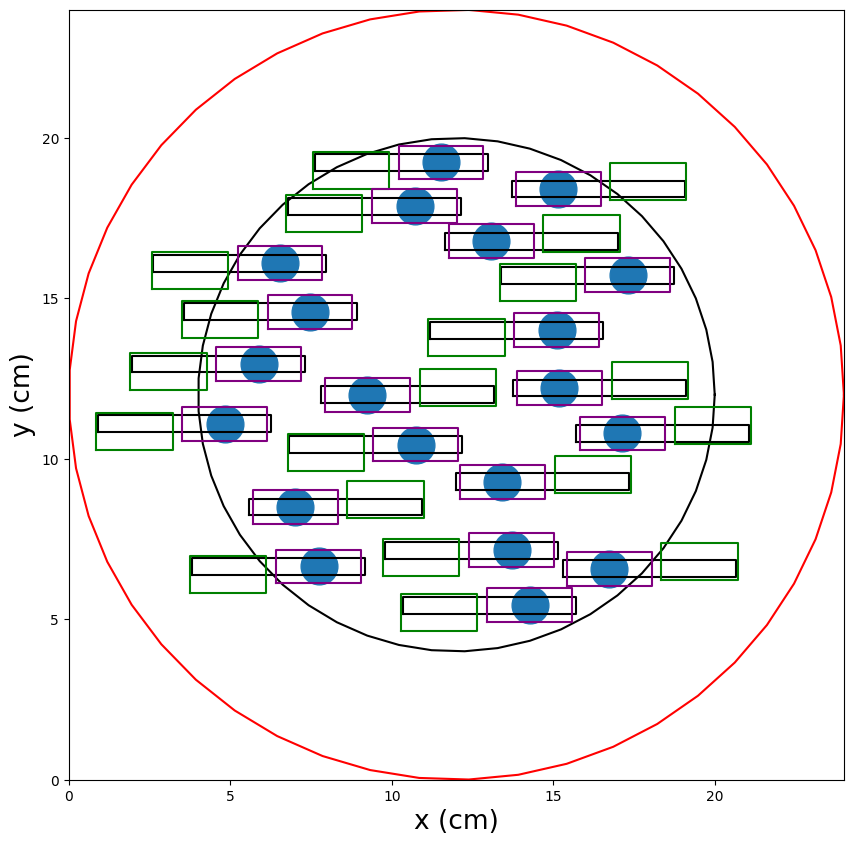

In [49]:



# Build the initial array
array,DCs = build_array(num_ants)
num_pairs = len(pair_finder(array))
max_sep = inner_array_radius*2-2*ant_radius
sep_ideal = np.linspace(2*ant_radius,max_sep,num_pairs)
print(f"Managed to create an array with {len(array)} antennas")
save_array_to_csv(array,"array_initial.csv")
#display_array(array)
display_array_full(array,DCs)

# Ignore this for now
num_pairs = len(pair_finder(array))
max_angle = np.pi
min_angle = -np.pi
angles_ideal=np.linspace(min_angle,max_angle,num_pairs)


### Randomly Generated Arrays

* May approach optimal design for small N, but will suffer with larger N

In [ ]:
# make a 10000 random ones and keep the best starting one
import time
scores_random = []
arrays_random = []
DCs_random = []
start = time.time()
N_arrays = 1000
best_scores = []
for n in range(N_arrays):
    
    array_temp,DCs_temp =build_array(num_ants) 
    if len(array)==num_ants:
        arrays_random.append(array_temp)
        DCs_random.append(DCs_temp)
        scores_random.append(main_scoring_function(arrays_random[n]))
        best_scores.append(max(scores_random))
        print(f"""
        --------------------
        Trial Design: {1+n}/{N_arrays}
        Current Best Score: {round(max(scores_random),5)}
        --------------------
        """)
    
    
    
    
print(f"Generated {N_arrays} arrays in {round((time.time()-start)/60,3)} minutes")
array = arrays_random[scores_random.index(max(scores_random))]
DCs = DCs_random[scores_random.index(max(scores_random))]

In [ ]:
plt.hist(scores_random,bins=60)
plt.title("Score for 1,000 randomly generated arrays",fontsize=15)
plt.xlabel("Score",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

### Optimise the array design based on the maximising the given scoring function

In [22]:
# Begin Optimisation
import time
start = time.time()
scores,the_best_array,the_best_array_DCs=optimise_array_design(array,iterations,tries_per_ant)
print(f"Took {round((time.time()-start)/60,2)} mins")

-------------------------------------
Iteration: 1. Trial Nudge No: 20. Score: 3.27368.
Time Per iteration: 0.966s

Array saved
-------------------------------------


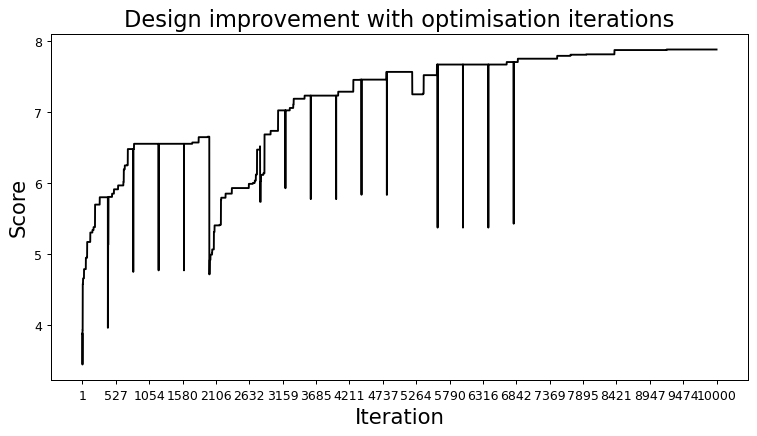

In [ ]:
# How did the "score" change over the optimisation process?
plt.figure(figsize=(10,5),dpi=90)
plt.plot(scores,color="black")
plt.title("Design improvement with optimisation iterations",fontsize=18)
plt.xlabel("Iteration",fontsize=17)
plt.ylabel("Score",fontsize=17)
labels = np.linspace(1,iterations,20)
plt.xticks(np.linspace(1,len(scores),20),[round(label) for label in labels])
plt.show()

In [ ]:
# Save this array along with the PCB orientations?

save_array_to_csv(the_best_array,"20Ant_GainFast12.csv")
save_DCs(the_best_array_DCs,"20Ant_GainFast_DCs12.csv")

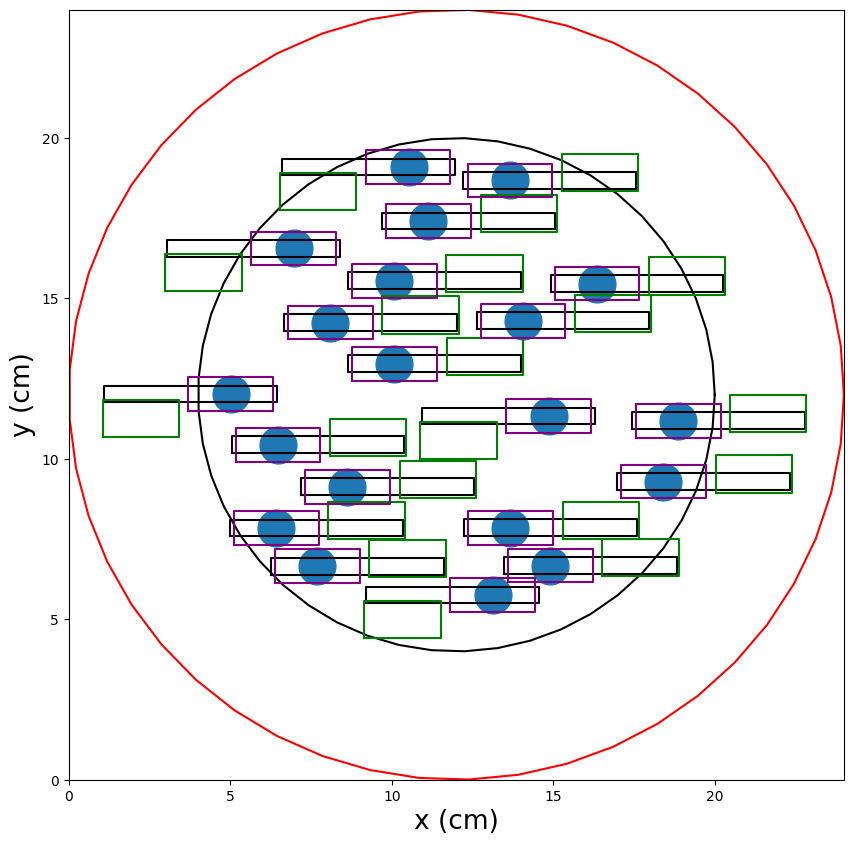

In [24]:
# Plot the array:
display_array_full(array,DCs)


#array = load_array("best_array.csv")
#DCs = load_DCs("best_array_DCs.csv")

In [ ]:
res= 150
width = 0.7
Z_depth = 1
circle_gain_crop_radius_m = 90e-3 # 90mm
circle_gain_crop_radius = circle_gain_crop_radius_m*(res/(width*2)) # pixels

x_axis = np.linspace(-width,width,res)
y_axis = np.linspace(-width,width,res)

# Create images
filename_im1 = "array_initial.csv"
im_start = create_image(filename_im1)
filename_im2 = "best_array.csv"
im_end = create_image(filename_im2)



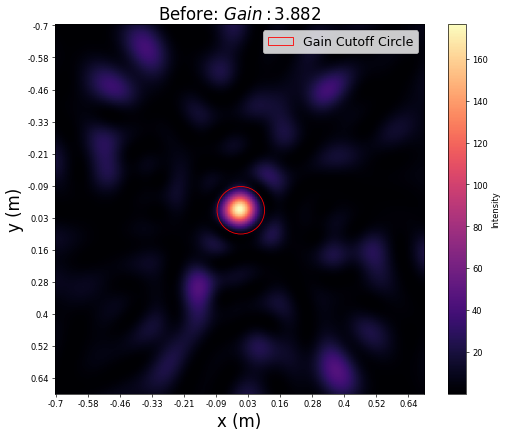

In [ ]:

plt.figure(figsize=(10,8),dpi=60)
plt.title(f"Before: $Gain: {round(calc_gain(im_start),3)}$",fontsize=20)
plt.imshow(im_start,cmap="magma")
plt.colorbar(label="Intensity")
plt.xlabel("x (m)",fontsize=20)
plt.ylabel("y (m)",fontsize=20)
# set the x and y axis ticks and labels
divisions = 11

# set the x and y axis ticks and labels
plt.gca().set_xticks(np.arange(0, res, step=res//divisions))
plt.gca().set_yticks(np.arange(0, res, step=res//divisions))
plt.gca().set_xticklabels([round(x,2) for x in x_axis[::res//divisions]])
plt.gca().set_yticklabels([round(y,2) for y in y_axis[::res//divisions]])

# Add a circle around the center of the image/plot
center_x = res/2
center_y = res/2
radius = circle_gain_crop_radius
circle = plt.Circle((center_x, center_y), radius, color='red', fill=False,label="Gain Cutoff Circle")
plt.gca().add_artist(circle)

plt.legend(fontsize=15)
plt.show()

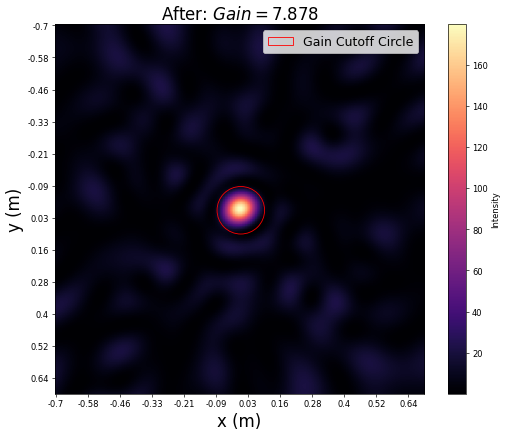

In [ ]:

plt.figure(figsize=(10,8),dpi=60)
plt.title(f"After: $Gain = {round(calc_gain(im_end),3)}$",fontsize=20)
plt.imshow(im_end,cmap="magma")
plt.colorbar(label="Intensity")
plt.xlabel("x (m)",fontsize=20)
plt.ylabel("y (m)",fontsize=20)

# set the x and y axis ticks and labels
divisions = 11

# set the x and y axis ticks and labels
plt.gca().set_xticks(np.arange(0, res, step=res//divisions))
plt.gca().set_yticks(np.arange(0, res, step=res//divisions))
plt.gca().set_xticklabels([round(x,2) for x in x_axis[::res//divisions]])
plt.gca().set_yticklabels([round(y,2) for y in y_axis[::res//divisions]])

# Add a circle around the center of the image/plot
center_x = res/2
center_y = res/2
radius = circle_gain_crop_radius
circle = plt.Circle((center_x, center_y), radius, color='red', fill=False,label="Gain Cutoff Circle")
plt.gca().add_artist(circle)

plt.legend(fontsize=15)

plt.show()

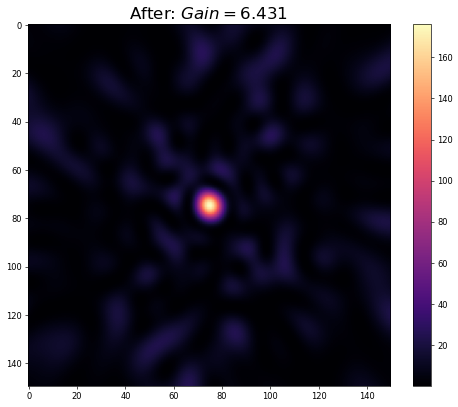

### ML Data Production - IGNORE

* Produce 100,000 arrays along with their gain score

* Then train a nural network to predict the gain score

* This could then be used to rapidly determine/predict the gain of a particular arrangment of antennas and therfore to produce an optimal array design

In [ ]:
# Need to adjust the build array function such that collision can be made. 
# This speeds up the array generation stage which will be the limiting factor

def build_array_ML(num_ants):
    array = []


    

    for trial_ant_indx in (range(num_ants)):

        x_pos,y_pos = np.random.uniform(0,array_radius*2),np.random.uniform(0,array_radius*2)
        array.append((x_pos,y_pos))

    return array

In [ ]:
res = 120

In [ ]:

import time
scores_random = []
arrays_random = []

start = time.time()
N_arrays = 100_000
best_scores = []
for n in tqdm(range(N_arrays)):
    
    array_temp =build_array_ML(num_ants) 
    scores_random.append(main_scoring_function(array_temp))
    arrays_random.append(array_temp)
        
    
    
print(f"Generated {N_arrays} arrays in {round((time.time()-start)/60,3)} minutes")
array = arrays_random[scores_random.index(max(scores_random))]

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:28:47<00:00, 18.77it/s]

Generated 100000 arrays in 88.794 minutes


In [ ]:
arrays = np.array(arrays_random)
scores = np.array(scores_random)

df_scores = pd.DataFrame(scores, columns = ['Score'])
df_scores.to_csv("Scores_20Ant_100000.csv")

In [ ]:
reshaped_arrays = arrays.reshape(N_arrays,2*num_ants)

In [ ]:

df_arrays = pd.DataFrame(reshaped_arrays, columns = [f'F_{i}' for i in range(2*num_ants)])
df_arrays.to_csv("Arrays_20Ant_100000.csv")

,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,...,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39
0,18.014298,17.796510,17.514899,8.913753,20.631651,2.254831,9.970554,9.361406,6.406841,23.760968,...,7.312646,0.790037,5.435328,3.338888,12.106486,23.712086,15.564779,7.030076,11.531350,21.468430
1,11.238955,5.332353,2.910180,15.189196,2.346170,10.454832,9.379502,4.536491,5.122130,21.313182,...,8.763368,9.637117,16.833549,2.734907,22.974808,7.914199,15.626773,19.134211,18.699360,7.401085
2,8.625709,19.591244,21.840987,4.960099,11.765869,11.259856,17.934635,3.261701,1.144884,11.607206,...,19.797687,21.836581,10.517825,12.368129,18.260321,16.123905,19.320594,2.815829,6.313422,10.726757
3,23.553385,7.321154,2.187884,0.595657,6.430283,21.351546,3.484353,12.052519,6.312064,0.019854,...,12.534810,20.839108,20.774268,6.448488,21.713314,10.659345,21.758051,20.471504,5.752132,4.084960
4,4.086235,23.924104,17.061008,18.789672,0.904073,2.018750,19.184243,22.677878,19.734591,17.636241,...,13.486423,4.402454,23.027225,20.528266,3.589369,21.453013,21.500159,4.439389,13.216146,5.755019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,8.275361,0.985155,6.080319,0.887822,6.717170,2.729849,9.847269,8.612156,2.483400,13.673979,...,22.228101,23.590057,11.520317,17.801360,1.279584,11.336706,12.086699,2.426441,12.479670,5.633778
99996,9.302714,7.747079,13.775426,3.056025,14.737734,2.119958,6.032926,18.170475,10.918413,9.285949,...,8.668933,4.285922,3.655006,2.262847,9.689687,22.765088,18.753931,3.266646,23.237381,6.567309
99997,4.395700,22.307303,8.346246,1.833046,9.083870,19.359683,23.619876,15.118820,6.895476,19.124555,...,20.088054,9.092802,16.382926,11.810414,19.235657,8.374384,13.056859,0.346905,22.694393,6.059315
99998,3.526128,10.332384,1.304326,18.009683,0.083506,14.954788,16.931363,14.302338,11.783177,8.067102,...,21.728559,8.628060,2.931538,0.515742,14.919450,20.395853,6.842416,17.799378,2.013509,0.852118


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b80a8b71-057d-4ced-958b-591356e28c8a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>